In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
# Directory where images are stored
base_dir = 'food'  # Update path ke dataset lokal
image_size = (224, 224)
batch_size = 32

# Mempersiapkan data dengan augmentasi
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Membuat generator untuk pelatihan, validasi, dan pengujian
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Jangan shuffle data test agar hasil evaluasi konsisten
)

# Load MobileNetV2 model with weights pre-trained on ImageNet
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# Add custom top layers
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

# Save the trained model
model.save('mobilenetv2_food_classification_finalmodel.keras')

Found 38000 images belonging to 95 classes.
Found 9500 images belonging to 95 classes.
Found 47500 images belonging to 95 classes.
Epoch 1/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 847s 708ms/step - accuracy: 0.2143 - loss: 3.3856 - val_accuracy: 0.4020 - val_loss: 2.3324
Epoch 2/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 841s 706ms/step - accuracy: 0.4237 - loss: 2.2446 - val_accuracy: 0.4486 - val_loss: 2.1716
Epoch 3/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 839s 705ms/step - accuracy: 0.4669 - loss: 2.0780 - val_accuracy: 0.4605 - val_loss: 2.1115
Epoch 4/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 834s 700ms/step - accuracy: 0.4893 - loss: 1.9831 - val_accuracy: 0.4679 - val_loss: 2.0991
Epoch 5/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 838s 704ms/step - accuracy: 0.4992 - loss: 1.9258 - val_accuracy: 0.4668 - val_loss: 2.1174
Epoch 6/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 836s 702ms/step - accuracy: 0.5143 - loss: 1.8611 - val_accuracy: 0.4769 - val_loss: 2.0533
Epoch 7/100
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 834s 701ms/step 

In [13]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,836,191 (10.82 MB)

 Trainable params: 192,735 (752.87 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 385,472 (1.47 MB)

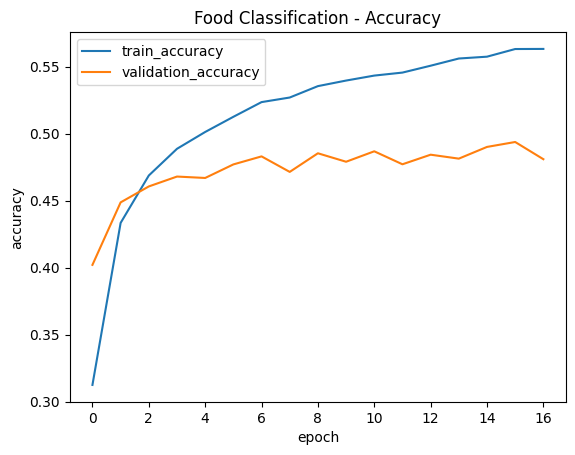

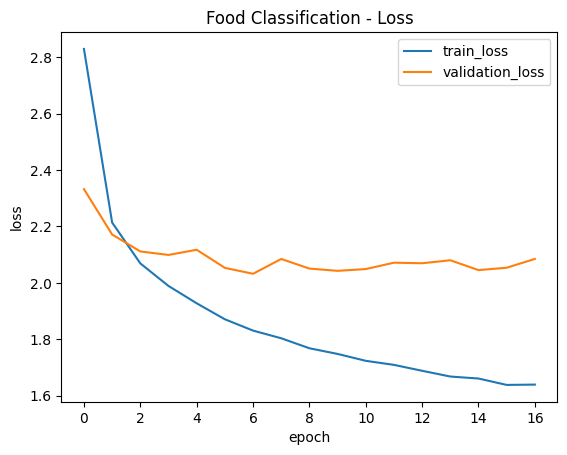

In [8]:
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

# Memvisualisasikan grafik akurasi dan loss dari history pelatihan model
plot_accuracy(history, 'Food Classification - Accuracy')
plot_loss(history, 'Food Classification - Loss')

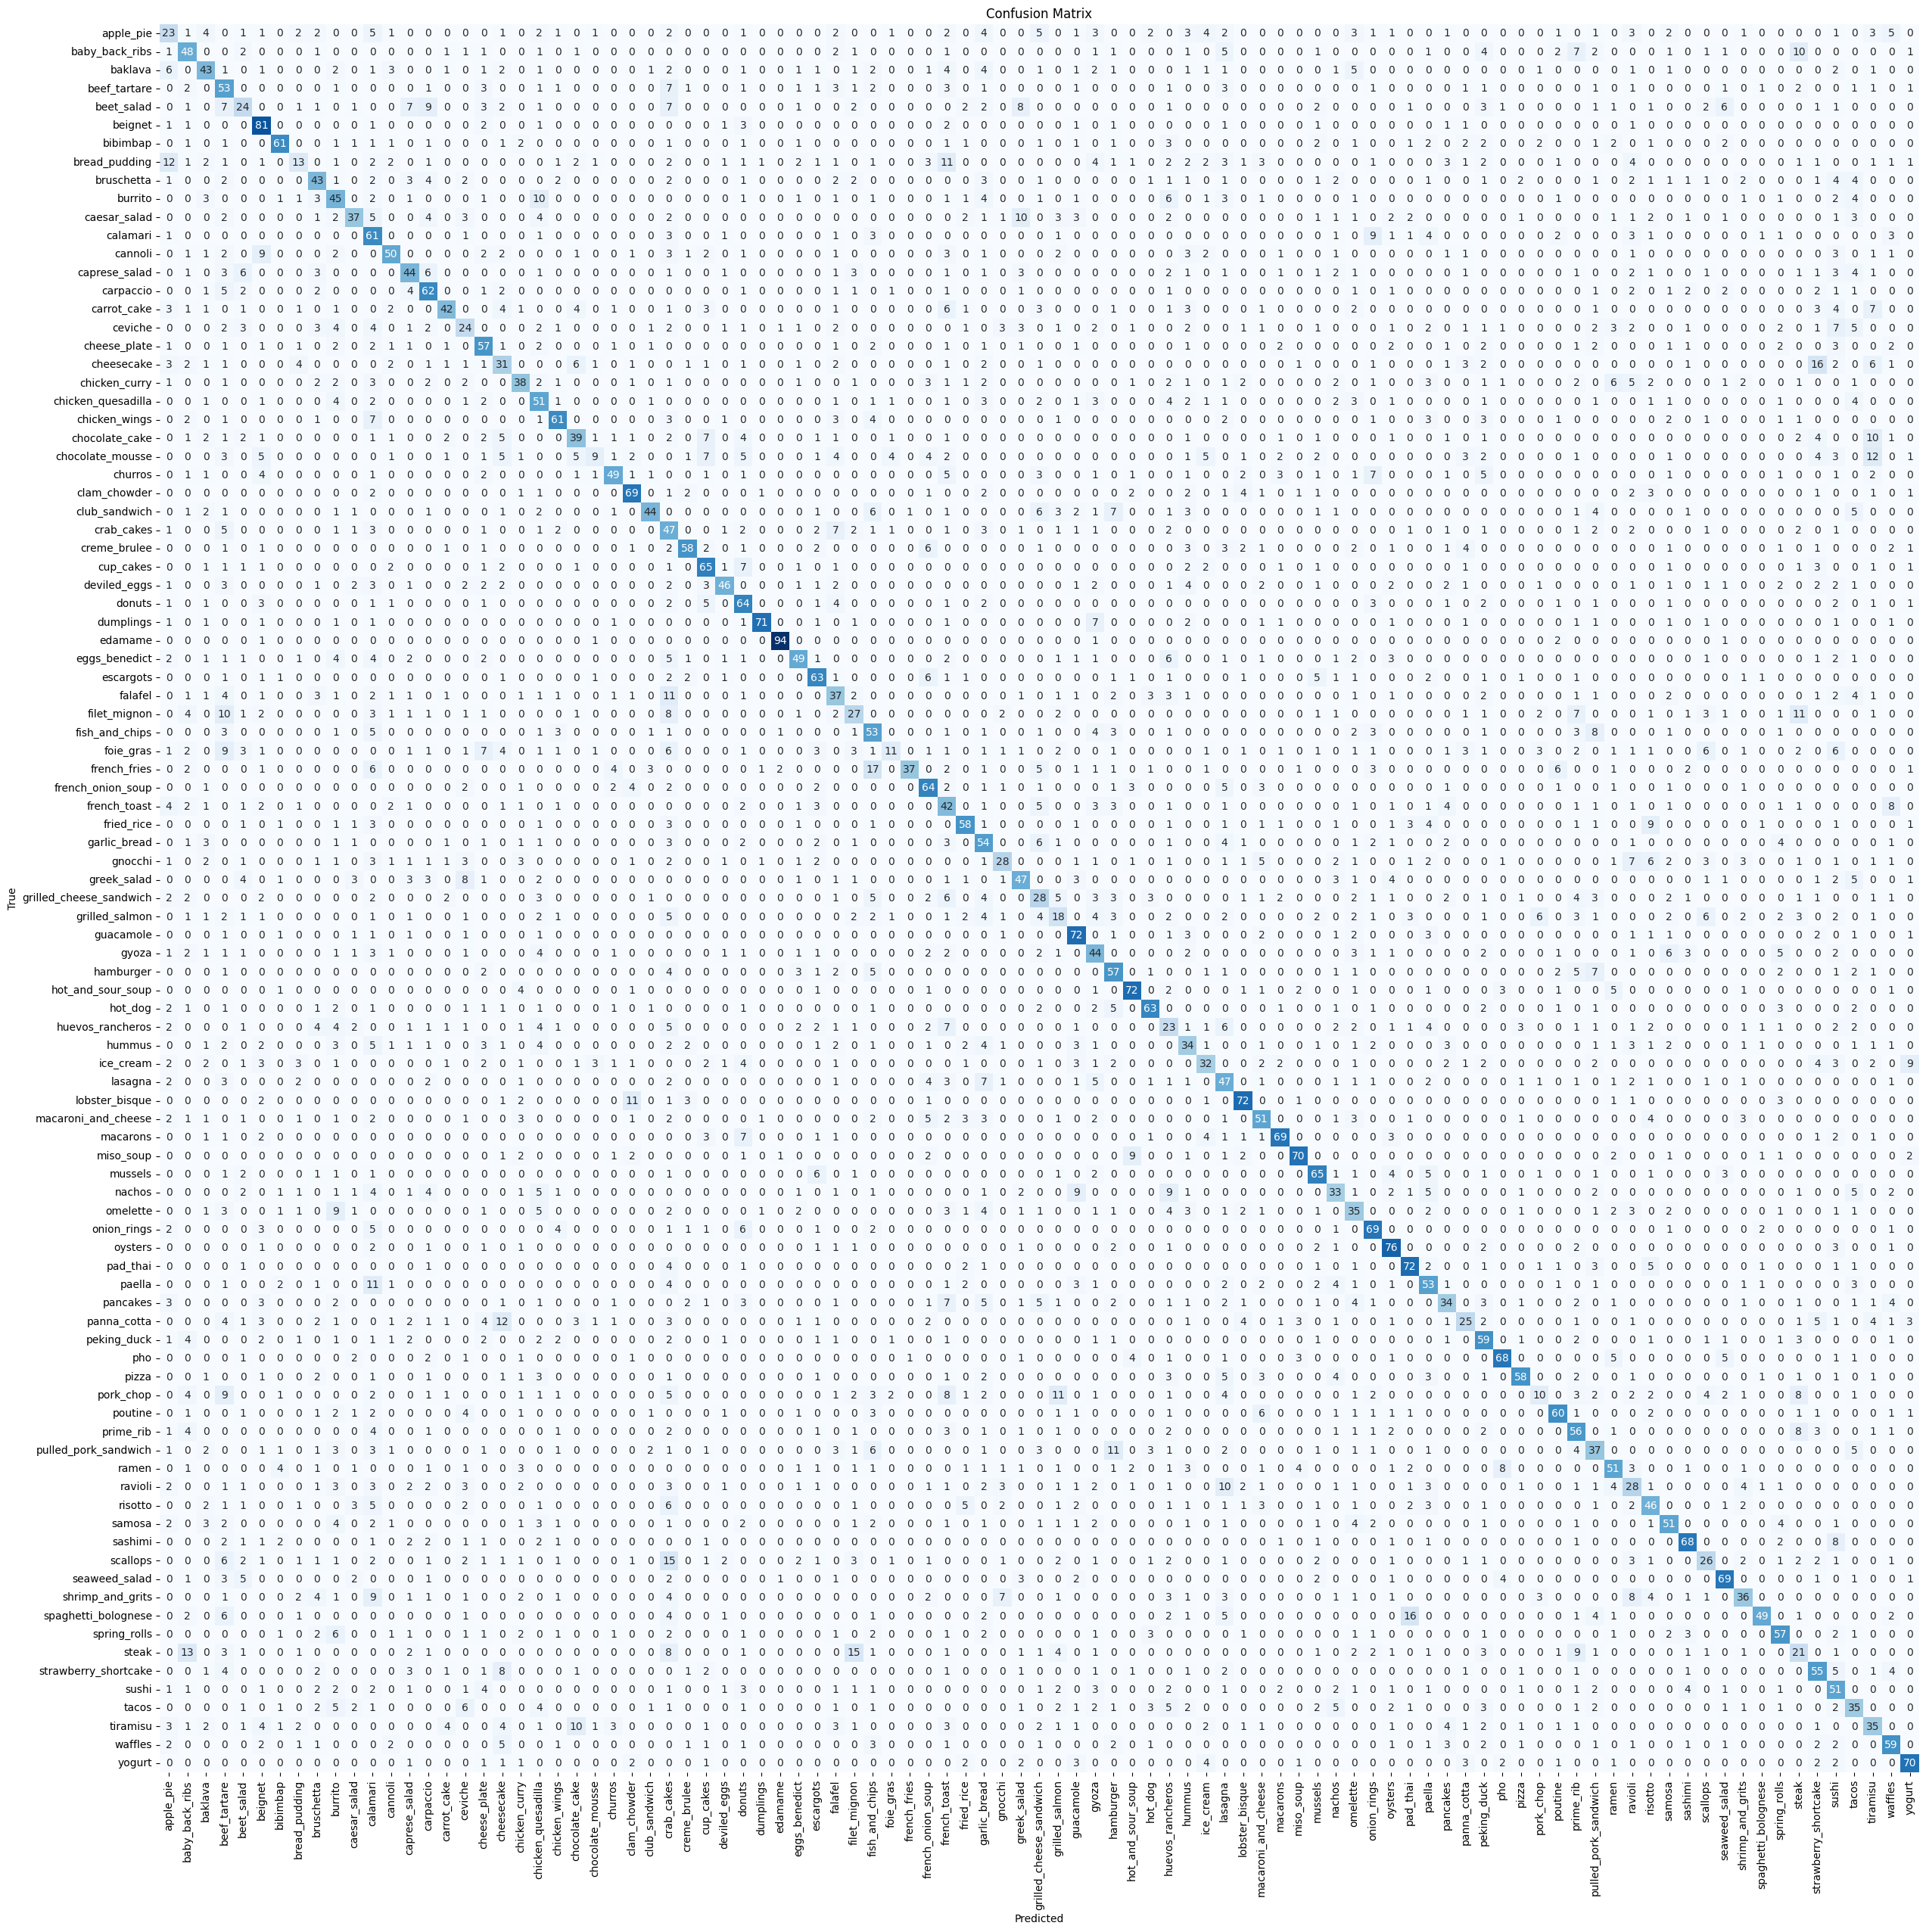

In [9]:
# Menghitung confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Langkah 1: Menggunakan data validasi penuh untuk evaluasi
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='validation',
    shuffle=False  # Jangan acak agar urutan data tetap untuk evaluasi
)

# Memuat model yang sudah disimpan
model = load_model('mobilenetv2_food_classification_finalmodel.keras')

# Melakukan prediksi pada seluruh data validasi
val_steps = validation_generator.samples // batch_size + 1
predictions = model.predict(validation_generator, steps=val_steps)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = validation_generator.classes

# Cek jumlah kelas pada data validasi
num_classes_val = len(np.unique(true_labels))
print(f"Jumlah kelas pada data validasi: {num_classes_val}")

# Mengambil nama kelas dari generator
class_names = list(validation_generator.class_indices.keys())
print(f"Jumlah kelas yang terbaca oleh validation_generator: {len(class_names)}")

# hitung akurasi
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Akurasi model: {accuracy * 100:.2f}%')

# Menghitung classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Menampilkan seluruh baris pada dataframe
pd.set_option('display.max_rows', None)

# Menampilkan classification report dalam bentuk tabel
print("Classification Report:")
print(df_report)

Found 9500 images belonging to 95 classes.


c:\Users\Faqih SA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


297/297 ━━━━━━━━━━━━━━━━━━━━ 167s 557ms/step
Jumlah kelas pada data validasi: 95
Jumlah kelas yang terbaca oleh validation_generator: 95
Akurasi model: 48.32%
Classification Report:
                         precision    recall  f1-score      support
apple_pie                 0.346939  0.170000  0.228188   100.000000
baby_back_ribs            0.534247  0.390000  0.450867   100.000000
baklava                   0.394366  0.560000  0.462810   100.000000
beef_tartare              0.444444  0.440000  0.442211   100.000000
beet_salad                0.357143  0.300000  0.326087   100.000000
beignet                   0.657658  0.730000  0.691943   100.000000
bibimbap                  0.642202  0.700000  0.669856   100.000000
bread_pudding             0.317073  0.130000  0.184397   100.000000
bruschetta                0.590909  0.260000  0.361111   100.000000
burrito                   0.666667  0.380000  0.484076   100.000000
caesar_salad              0.515464  0.500000  0.507614   100.000000
ca

In [2]:
# Visualisasi hasil
def plot_images(images, true_labels, preds_labels):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[preds_labels[i]]}")
        plt.axis('off')
    plt.show()

def get_sample_from_generator(generator, num_samples=16):
    samples = []
    labels = []
    for _ in range((num_samples // batch_size) + 1):  # Ambil lebih dari satu batch jika diperlukan
        batch_images, batch_labels = next(generator)
        samples.extend(batch_images)
        labels.extend(batch_labels)
        if len(samples) >= num_samples:
            break
    return np.array(samples[:num_samples]), np.array(labels[:num_samples])

# Ambil contoh gambar dari validation set
sample_images, sample_labels = get_sample_from_generator(validation_generator)

# Memuat model yang sudah disimpan
model = load_model('mobilenetv2_food_classification_finalmodel.keras')

# Prediksi dan hitung label
sample_preds = model.predict(sample_images)
sample_preds_labels = np.argmax(sample_preds, axis=1)
true_labels = np.argmax(sample_labels, axis=1)

# Visualisasi hasil
plot_images(sample_images, true_labels, sample_preds_labels)

# Menghitung akurasi
accuracy = np.sum(sample_preds_labels == true_labels) / len(true_labels)
print(f'Akurasi model pada contoh gambar: {accuracy * 100:.2f}%')

NameError: name 'validation_generator' is not defined

<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:43: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Faqih SA\AppData\Local\Temp\ipykernel_4956\2073822044.py:43: SyntaxWarning: invalid escape sequence '\d'
  image_path = 'input_test\download.jpeg'  # Ganti dengan path gambar makanan yang ingin diprediksi


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


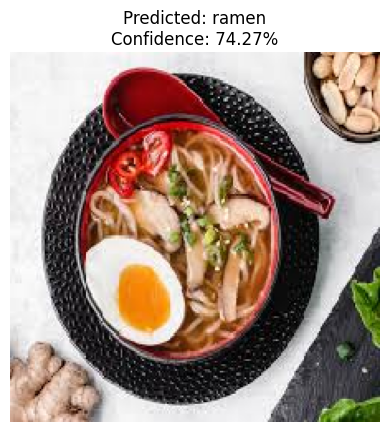

No nutritional information available.


In [28]:
# Fungsi untuk memuat model dan memprediksi gambar baru
def load_and_predict(image_path):
    model = load_model('mobilenetv2_food_classification_finalmodel.keras')
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array)
    predicted_label = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)
    
    return predicted_label, confidence, img

# Mengambil informasi nutrisi dari API Ninjas
def get_nutrition_info(food_item):
    api_url = "https://api.api-ninjas.com/v1/nutrition?query={}".format(food_item.replace('_', ' '))
    response = requests.get(api_url, headers={'X-Api-Key': 'mlanYP3fhRVvn+0Mq1GYJg==iYsnN43GcGHbtkzO'})
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Fungsi utama untuk memprediksi gambar dan menampilkan hasilnya
def predict_and_display(image_path):
    predicted_label, confidence, img = load_and_predict(image_path)
    nutrition_info = get_nutrition_info(predicted_label)
    
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}\nConfidence: {confidence*100:.2f}%')
    plt.axis('off')
    plt.show()
    
    if nutrition_info:
        print(f"Nutritional information for {predicted_label}:")
        for item in nutrition_info:
            print(f"Calories: {item['calories']}, Fat: {item['fat_total_g']}g, Saturated Fat: {item['fat_saturated_g']}g, "
                  f"Sodium: {item['sodium_mg']}mg, Potassium: {item['potassium_mg']}mg, Cholesterol: {item['cholesterol_mg']}mg, "
                  f"Total Carbohydrates: {item['carbohydrates_total_g']}g, Fiber: {item['fiber_g']}g, Sugar: {item['sugar_g']}g")
    else:
        print("No nutritional information available.")

# Contoh penggunaan
image_path = 'input_test\download.jpeg'  # Ganti dengan path gambar makanan yang ingin diprediksi
predict_and_display(image_path)